In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import math
%matplotlib inline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
sales_of_company_x = pd.read_csv("../1-Intro/Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("../1-Intro/Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("../1-Intro/Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("../1-Intro/Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("../1-Intro/Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("../1-Intro/Series/daily-total-female-births-in-cal.csv")

In [3]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

Воспользуемся функциями с лекции:

In [4]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [5]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    n = weights.shape[0]
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [6]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [7]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [8]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [9]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [10]:
def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4',linestyle='dashed', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [11]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

## Mean monthly air temperature (Deg. F) Nottingham Castle

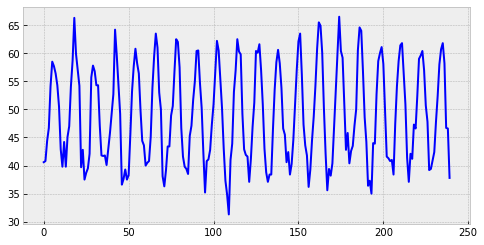

In [12]:
s4 = np.array(mean_monthly_temp['Deg'])
with plt.style.context('bmh'):
        plt.figure(figsize=(8, 4))
        plt.plot(s4, color='blue')

В ряду видна сезонность, но отсутствует тренд. Используем для приближения ряда метод Хольта-Винтерса, с большим альфа (вес предыдущих значений), с малым бета (нет тренда) и большим гамма (есть сезонность).

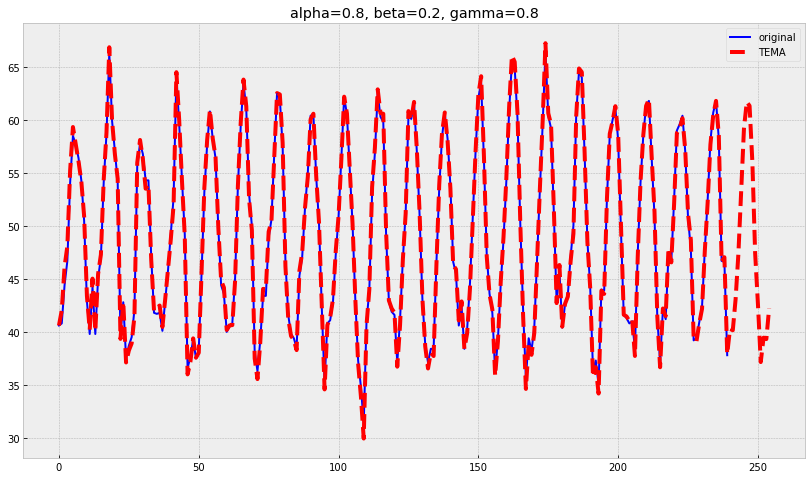

In [15]:
plot_tema(0.8,0.2,0.8, ser=s4, ser_to_plot=s4, n_preds=15)

In [16]:
series = pd.Series(s4)

In [17]:
train, test, val = series[:190], series[200:220], series[220:]

In [18]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [19]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 74.50714783280813
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.35021594e+00, -2.84217094e-05,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 40
      nit: 9
   status: 0
  success: True
        x: array([1.        , 0.00144041, 1.        ])


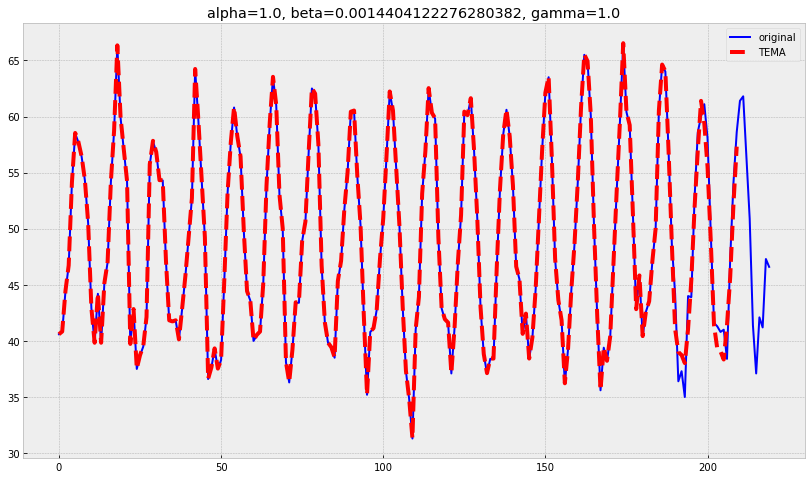

In [20]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:220], n_preds=len(test))

Теперь стационарный ряд.

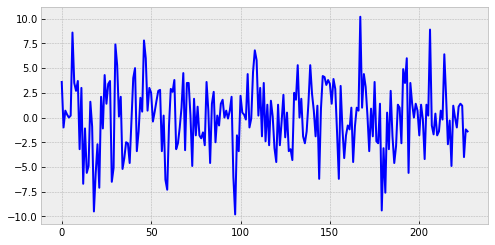

In [22]:
s4_1 = s4[12:] - s4[:-12]
with plt.style.context('bmh'):
    plt.figure(figsize=(8, 4))
    plt.plot(s4_1, color='blue')

Нет сезонности, тренда. Здесь скользящее среднее или взвешенное скользящее среднее оптимально.

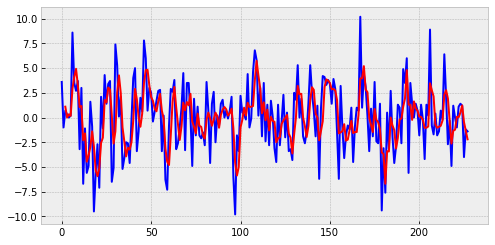

In [23]:
s4__ = moving_average(s4_1,3)
with plt.style.context('bmh'):
    plt.figure(figsize=(8, 4))
    plt.plot(s4_1, color='blue')
    plt.plot(s4__, color='red')

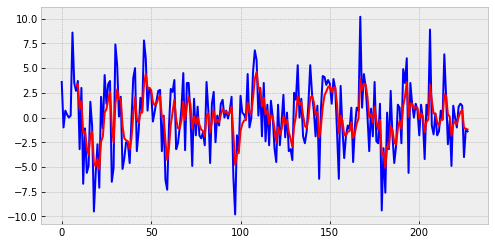

In [24]:
s4__ = weighted_moving_average(s4_1,20,[1,1,2,3,5,8,13,21,34])
with plt.style.context('bmh'):
    plt.figure(figsize=(8, 4))
    plt.plot(s4_1, color='blue')
    plt.plot(s4__, color='red')